# Multi species model

The [train-crown](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-crown.ipynb) notebook shows how to use the pre-trained tree crown detection of [DeepForest](https://deepforest.readthedocs.io/en/latest) [1] with our dataset, both for inference as well as how to fine-tune it.

In this notebook, we will show how to not only detect tree crowns but also classify them into different species/groups. Without loss of generality, we will first focus on distinguishing between deciduous and conifer trees (as introduced in the [train-test-split](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-test-split.ipynb) notebook and annotated accordingly).

In [ ]:
import tempfile
from os import path

import matplotlib.pyplot as plt
import pandas as pd
from deepforest import evaluate, main, model, utilities

from swiss_urban_trees import deepforest_utils, plot

In [ ]:
annot_df_filepath = "../data/raw/sitg-orthophoto-2019-tiles/annot.csv"
tile_dir = "../data/raw/sitg-orthophoto-2019-tiles"

# model args
num_workers = 4
patch_overlap = 0.1
# in view of the results of the `train-crown.ipynb` notebooks, we ommit patch_size=200
patch_sizes = [300, 400, 500]
iou_threshold = 0.15

# viz args
# annot_color = [0, 165, 255]
# pred_color = [0, 165, 255]
# _base_plot_kwargs = {"linewidth": 2, "facecolor": "none", "cmap": "tab10"}
# plot_annot_kwargs = dict({"column": "label"}, **_base_plot_kwargs)
# multi_plot_pred_kwargs = dict({"column": "label"}, **_base_plot_kwargs)
# crop_plot_pred_kwargs = dict({"column": "cropmodel_label"}, **_base_plot_kwargs)
plot_kwargs = {"column": "label", "linewidth": 2, "facecolor": "none", "cmap": "tab10"}
figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]


# train args
epochs = 5
gpus = None  # set to -1 to use all available GPUs

## Read annotations

In [ ]:
annot_gdf = utilities.read_file(pd.read_csv(annot_df_filepath))
annot_gdf["image_path"] = annot_gdf["image_path"].str.replace("jpeg", "tif")
annot_gdf.head()

,xmin,ymin,xmax,ymax,label,image_path,geometry
0,120,248,145,282,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((145 248, 145 282, 120 282, 120 248, ..."
1,133,32,150,47,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((150 32, 150 47, 133 47, 133 32, 150 ..."
2,57,165,77,185,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((77 165, 77 185, 57 185, 57 165, 77 1..."
3,65,189,102,220,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((102 189, 102 220, 65 220, 65 189, 10..."
4,91,179,130,210,deciduous,2499724.7_1119593.6_2499974.7_1119843.6.tif,"POLYGON ((130 179, 130 210, 91 210, 91 179, 13..."


## Multi-species model

The first approach that we will try is to train a single multi-species model. Let us start by loading the Deepforest prebuilt model.

In [ ]:
deepforest_model = main.deepforest(config_args={"workers": num_workers})
deepforest_model.use_release()

Reading config file: /home/martibosch/mambaforge/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml
setting config workers to 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: /home/martibosch/mambaforge/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


As suggested [in the DeepForest documentation](https://deepforest.readthedocs.io/en/v1.4.1/user_guide/06_multi_species.html), we can start with the backbone and box prediction portions of the prebuilt model and then train a new classification model (regression head):

In [ ]:
# get label to id mappings (both ways)
label_dict = {label: i for i, label in enumerate(annot_gdf["label"].unique())}
numeric_to_label_dict = {val: label for label, val in label_dict.items()}

# preapre multi-class model
multi_model = main.deepforest(
    label_dict=label_dict,
    config_args={"num_classes": len(label_dict), "workers": num_workers},
)
# load single class backbone into the new multi-class model
multi_model.model.backbone.load_state_dict(deepforest_model.model.backbone.state_dict())
multi_model.model.head.regression_head.load_state_dict(
    deepforest_model.model.head.regression_head.state_dict()
)
# load regression head into the new multi-class model
multi_model = deepforest_utils.retrain_model(
    multi_model, tile_dir, annot_gdf, epochs=epochs, gpus=gpus
)

Reading config file: /home/martibosch/mambaforge/envs/swiss-urban-trees/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml
setting config num_classes to 2
setting config workers to 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type                  | Params | Mode 
-------------------------------------------------------------
0 | model      | RetinaNet             | 32.2 M | train
1 | iou_metric | IntersectionOverUnion | 0      | train
2 | mAP_metric | MeanAveragePrecision  | 0      | train
-------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.2 M    Total params
128.675   Total estimated model params size (MB)
204       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|                                                                                                                                         | 0/1 [00:00<?, ?it/s]

Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  0.12it/s, v_num=42]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  0.12it/s, v_num=42]
--- Model retrained in 47.19 seconds ---


Let us now use this new model for inference (for a single image and patch size):

In [ ]:
img_filename = annot_gdf["image_path"].unique()[0]
# let us try a single patch size to start with
patch_size = 400
multi_pred_gdf = multi_model.predict_tile(
    path.join(tile_dir, f"{path.splitext(img_filename)[0]}.tif"),
    patch_size=patch_size,
    patch_overlap=patch_overlap,
    iou_threshold=iou_threshold,
)
multi_pred_gdf

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  0.38it/s]
0 predictions in overlapping windows, applying non-max supression
0 predictions kept after non-max suppression


The multi-species model did not predict any tree, which could be due to many issues with our approach - most likely, the main one being that our annotated tile is not enough to train a proper regression head for multi-species classification. At this point, it seems clear that we need to annotate more tiles, nevertheless, let us try an alternative approach first.

## The crop model

Instead of using a single model to detect tree crowns and then classify them into tree species (or groups of species), we can instead use the prebuilt model for tree crown detection and then apply a follow-up model to the predicted bounding boxes. This is the purpose of the [crop model](https://deepforest.readthedocs.io/en/v1.4.1/user_guide/03_cropmodels.html) feature of DeepForest.

We will first use our annotated bounding boxes and tree species labels to extract the corresponding image. The cropped images and labels will then be used to train the crop model (i.e., an [image classification](https://paperswithcode.com/task/image-classification) model mapping each extracted image as a whole to the tree species label:

In [ ]:
crop_model = model.CropModel(num_classes=len(label_dict))
crop_model.create_trainer(fast_dev_run=True)

with tempfile.TemporaryDirectory() as tmp_dir:
    crop_model.write_crops(
        tile_dir,
        annot_gdf["image_path"].str.replace(".jpeg", ".tif").values,
        annot_gdf[["xmin", "ymin", "xmax", "ymax"]].values,
        annot_gdf["label"].values,
        tmp_dir,
    )
    # the second argument should be a directory with data for evaluation but we do not
    # have that yet
    crop_model.load_from_disk(tmp_dir, tmp_dir)
    crop_model.trainer.fit(crop_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

  | Name             | Type                | Params | Mode 
-----------------------------------------------------------------
0 | model            | ResNet              | 23.5 M | train
1 | accuracy         | MulticlassAccuracy  | 0      | train
2 | total_accuracy   | MulticlassAccuracy  | 0      | train
3 | precision_metric | MulticlassPrecision | 0      | train
4 | metrics          | MetricCollection    | 0      | train
-----------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.82it/s]
Validation: |                                                                                                                                          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s]


We can now combine both models to perform multi-species tree detection:

In [ ]:
img_filenames = pd.Series(annot_gdf["image_path"].unique())
crop_pred_gdf = pd.concat(
    [
        deepforest_model.predict_tile(
            path.join(tile_dir, f"{path.splitext(img_filename)[0]}.tif"),
            patch_size=patch_size,
            patch_overlap=patch_overlap,
            iou_threshold=iou_threshold,
            crop_model=crop_model,
        ).assign(**{"patch_size": patch_size})
        for img_filename in img_filenames
        for patch_size in patch_sizes
    ],
    ignore_index=True,
)
crop_pred_gdf = crop_pred_gdf.assign(
    **{"label": crop_pred_gdf["cropmodel_label"].map(numeric_to_label_dict)}
)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  0.57it/s]
279 predictions in overlapping windows, applying non-max supression
202 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:15<00:00,  0.58it/s]
150 predictions in overlapping windows, applying non-max supression
113 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  0.55it/s]
68 predictions in overlapping windows, applying non-max supression
45 predictions kept after non-max suppression
Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████

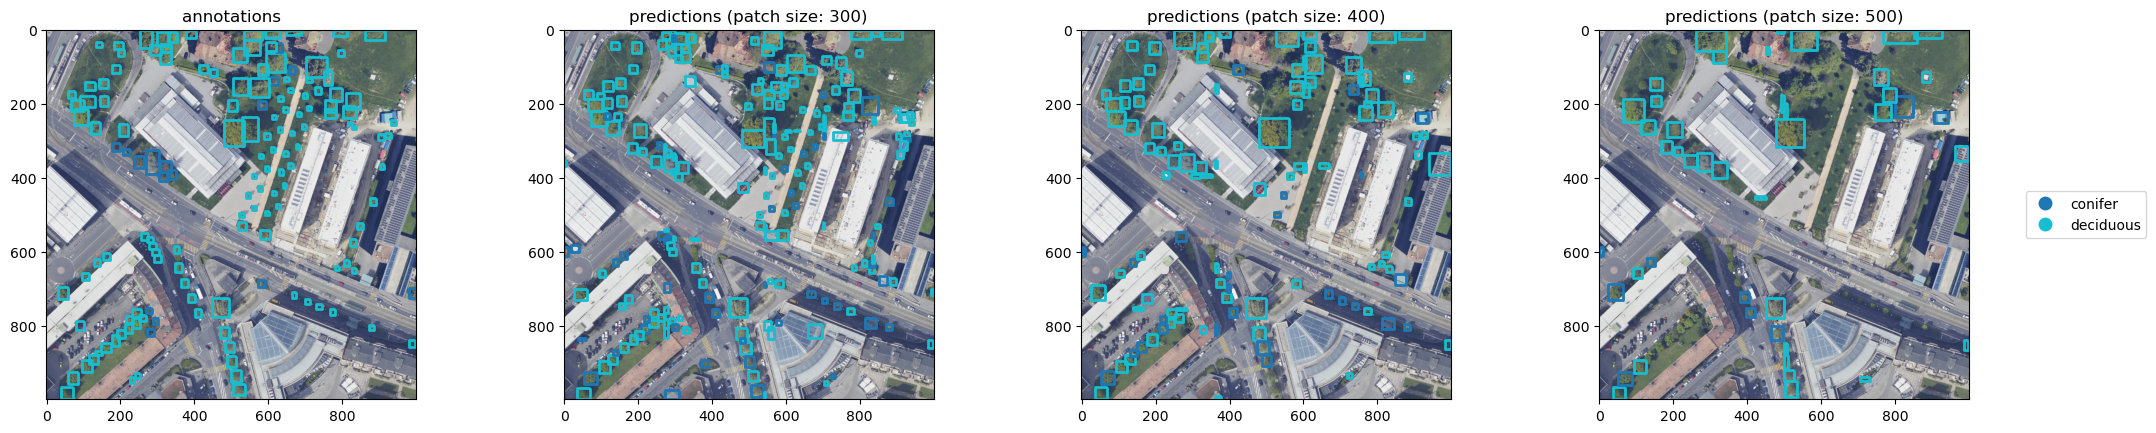

In [ ]:
fig = plot.plot_annot_vs_pred(
    annot_gdf,
    crop_pred_gdf,
    tile_dir,
    plot_annot_kwargs=plot_kwargs,
    plot_pred_kwargs=plot_kwargs,
)

In [ ]:
metrics_df = deepforest_utils.compute_metrics_df(
    annot_gdf, crop_pred_gdf, tile_dir, iou_threshold=iou_threshold
)
metrics_df

,IoU,recall,precision,F1
patch_size,,,,
300,0.565952,0.836735,0.608911,0.704871
400,0.487934,0.769912,0.769912,0.769912
500,0.438173,0.800000,0.800000,0.800000


In [ ]:
class_recall_df = pd.concat(
    [
        evaluate.evaluate_boxes(
            crop_pred_gdf[crop_pred_gdf["patch_size"] == patch_size],
            annot_gdf,
            tile_dir,
            iou_threshold=iou_threshold,
        )["class_recall"].assign(**{"patch_size": patch_size})
        for patch_size in patch_sizes
    ],
    ignore_index=True,
)
class_recall_df

,label,recall,precision,size,patch_size
0,conifer,0.000000,0.000000,14,300
1,deciduous,0.761468,0.855670,109,300
2,conifer,0.000000,0.000000,11,400
3,deciduous,0.763158,0.840580,76,400
4,conifer,0.000000,0.000000,5,500
5,deciduous,0.774194,0.827586,31,500


As we can see, the precision and recall for "deciduous" trees are high for all patch sizes, nonetheless not a single "conifer" has been correctly classified. This is likely due to the low occurence of "conifer" trees in the annotated data. As shown in the [train-test-split](https://github.com/martibosch/swiss-urban-trees/blob/main/notebooks/train-test-split.ipynb) notebook, we could use the [cantonal tree inventory of Geneva](https://sitg.ge.ch/donnees/sipv-ica-web-public-tot) to select further training tiles, maybe even combine it with active learning criteria such as margin sampling or the like.

#### TODO: train the crop model with the [SITG Orthophoto 2019 at 5 cm](https://sitg.ge.ch/donnees/image-aerienne-ortho-2019-05), without downlsampling to 25 cm for Swiss-wide compatibility with [SWISSIMAGE](https://www.swisstopo.admin.ch/en/orthoimage-swissimage-10) or at least downsampling to 10 cm for compatibility with SWISSIMAGE at the plain areas and main alpine valleys.

## References

1. Weinstein, B. G., Marconi, S., Aubry‐Kientz, M., Vincent, G., Senyondo, H., & White, E. P. (2020). DeepForest: A Python package for RGB deep learning tree crown delineation. Methods in Ecology and Evolution, 11(12), 1743-1751.